# Plotting

Nearly all of the `hypertools` functionality may be accessed through the main `plot` function.  This design enables complex data analysis, data manipulation, and plotting to be carried out in a single function call.  To use it, simply pass your samples by features dataset(s) [in the form of a numpy array, pandas dataframe, or (mixed) list] to the `plot` function. Let's explore!

## Import Hypertools and other libraries for tutorial

In [19]:
import hypertools as hyp
import numpy as np
import scipy
import pandas as pd
from scipy.linalg import toeplitz
from copy import copy

%matplotlib inline

## Load your data

We will load one of the sample datasets. This dataset consists of 8,124 samples of mushrooms with various text features.

In [6]:
mushrooms = hyp.load('mushrooms')

We can peek at the first few rows of the dataframe using the pandas function `head()`.

In [7]:
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Plot with default settings

`Hypertools` can plot your high-dimensional data quickly and easily with little user-generated input. By default, `hypertools` automatically reduces your data via incremental principal component analysis (if dimensions > 3) and plots plots a 3D line plot where the axes represent the top 3 principal components of the dataset. 

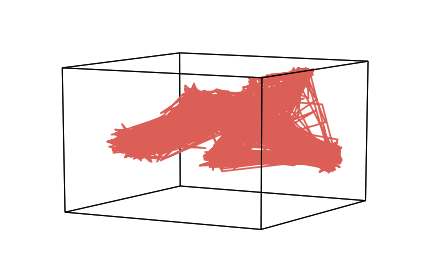

In [8]:
geo = hyp.plot(mushrooms) # plots a line

The default is to output a line connecting the datapoints (useful for timecourse visualizations). In this case, showing individual points is more intuitive.  To show the individual points, simply pass the `'.'` format string in the second argument position, or in any position using `fmt='.'`.

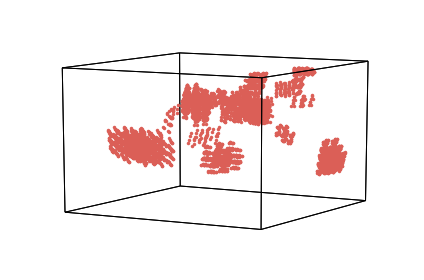

In [9]:
geo = hyp.plot(mushrooms, '.') # plots points

## Plot in 2D 

We can also opt to plot high dimensional data in two dimensional space, rather than 3D, by passing the 'ndims' argument.

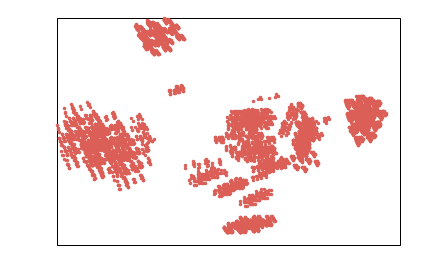

In [10]:
geo = hyp.plot(mushrooms, '.', ndims=2)

## Using other dimensionality reduction algorithms

To explore a data reduction method aside from the default (PCA), use `reduce` argument. Here, we pass the reduce argument a string.

Other supported reduction models include: PCA, IncrementalPCA, SparsePCA, MiniBatchSparsePCA, KernelPCA, FastICA, FactorAnalysis, TruncatedSVD, DictionaryLearning, MiniBatchDictionaryLearning, TSNE, Isomap, SpectralEmbedding, LocallyLinearEmbedding, MDS

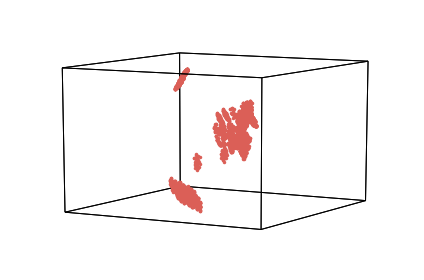

In [11]:
geo = hyp.plot(mushrooms, '.', reduce='SparsePCA')

### Parameter Specifications

For finer control of the parameters, you can pass the reduce argument a dictionary (see scikit learn documentation about parameter options for specific reduction techniques).

In [17]:
hyp.plot(mushrooms, reduce={'model' : 'PCA', 'params' : {'n_components' : 10}})

TypeError: 'NoneType' object is not iterable

## Coloring by group

To color your datapoints by group labels, pass the `group` argument. It accepts strings, ints, and floats, or a list of these. You must pass group the same number of labels as you have rows in your data matrix.

Here, we group the data in five different chunks of equal size (size #points / 5) for simplicity. Note that we pass ints, strings, floats, and None in the same list to the group argument.

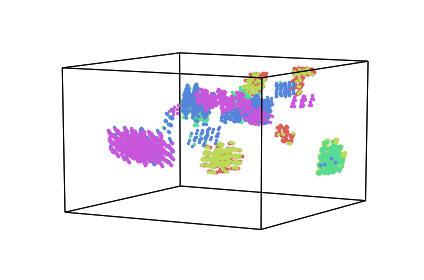

In [18]:
split = int(mushrooms.shape[0]/ 5)
groupings = [1]*split + ['two']*split + [3.0]*split + [None]*split + ['four']*split
geo_group = hyp.plot(mushrooms, '.', group=groupings)

### Adding a legend

When coloring by group, you may want a legend to indicate group type. Passing legend=True will generate the legend based on your groupings.

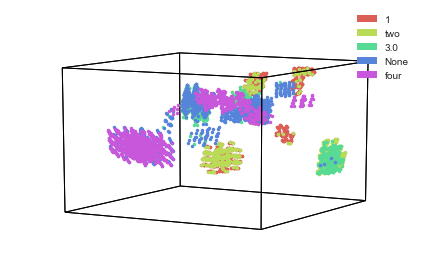

In [21]:
split = int(mushrooms.shape[0]/5)
groupings = [1]*split + ['two']*split + [3.0]*split + [None]*split + ['four']*split
geo_group = hyp.plot(mushrooms, '.', group=groupings, legend=True)

## Interpolating missing data

Missing data points? No problem! `Hypertools` will fill missing values via probabalistic principal components analysis (PPCA). Here, we generate a small synthetic dataset, remove a few values, then use PPCA to interpolate those missing values. Then, we plot the original data and the interpolated data, for comparison.  The one exception is that in cases where the entire data sample (row) is nans.  In this scenario, there is no data for PPCA to base its guess on, so the inference will fail.

/Users/andyheusser/Documents/github/hypertools/hypertools/_shared/helpers.py:181: UserWarning: Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)
  warnings.warn('Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)')


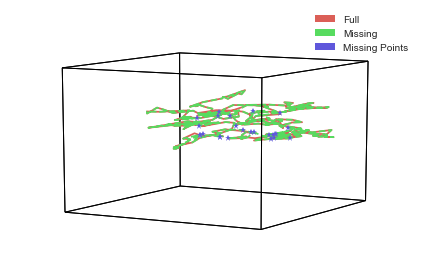

In [36]:
# simulate data
K = 10 - toeplitz(np.arange(10))
data1 = np.cumsum(np.random.multivariate_normal(np.zeros(10), K, 250), axis=0)
data2 = copy(data1)

# randomly remove 5% of the data
missing = .01
inds = [(i,j) for i in range(data1.shape[0]) for j in range(data1.shape[1])]
missing_data = [inds[i] for i in np.random.choice(int(len(inds)), int(len(inds)*missing))]
for i,j in missing_data:
    data2[i,j]=np.nan

# reduce the data
data1_r,data2_r = hyp.reduce([data1, data2], ndims=3)

# pull out missing inds
missing_inds = hyp.tools.missing_inds(data2)
missing_data = data2_r[missing_inds, :]

# plot
geon_nan = hyp.plot([data1_r, data2_r, missing_data], ['-', '--', '*'],
         legend=['Full', 'Missing', 'Missing Points'])

## Labeling plotted points

The `labels` argument accepts a list of labels for each point, which must be the same length as the data (the number of rows). If no label is wanted for a particular point, simply input `None`. In this example, we have made use of `None` in order to label only three points of interest (the first, second, and last in our set). 

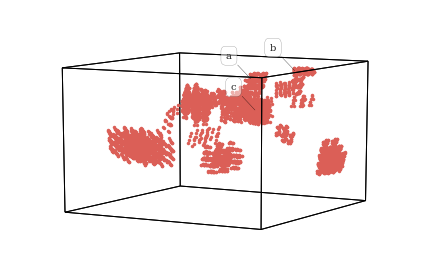

In [37]:
num_unlabeled = int(mushrooms.shape[0])-3
labeling = ['a','b'] + [None]*num_unlabeled + ['c']
label = hyp.plot(mushrooms, '.', labels = labeling)

## Data Clustering

Hypertools can also auto-cluster your datapoints with the `n_clusters` argument. To implement, simply set `n_clusters` to an integer.

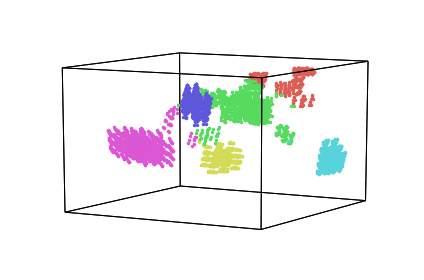

In [38]:
geo_cluster = hyp.plot(mushrooms, '.', n_clusters = 6)

## Normalization

For quick, easy data normalization of the input data, pass the normalize argument.

You can pass the following arguments as strings: 
+ across - columns z-scored across lists (default)
+ within - columns z-scored within each list
+ row - each row z-scored 

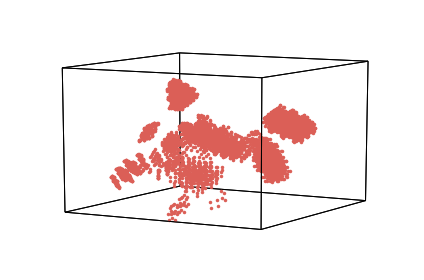

In [39]:
geo_cluster = hyp.plot(mushrooms, '.', normalize = 'within')

## Aligning datasets with different coordinate systems

You can also align multiple datasets using the hypertools plot function in order to visualize data in a common space. This is useful, if you have more than one high-dimensional dataset that is related to the same thing.  For example, consider a brain imaging (fMRI) dataset comprised of multiple subjects watching the same movie. Voxel A in subject 1 may not necessarily be Voxel A in subject 2.  Alignment allows you to rotate and scale multiple datasets so they are in maximal alignment with one another.

To do so, pass one of the following strings to the align argument (as shown below):

+ `hyper` - hyperalignment algorithm (default) See: http://haxbylab.dartmouth.edu/publications/HGC+11.pdf
+ `SRM` - shared response model algorithm. See: https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model.pdf

Below, is a simple example of a spiral.

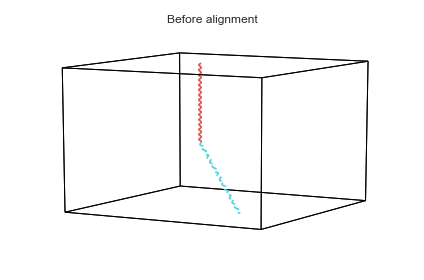

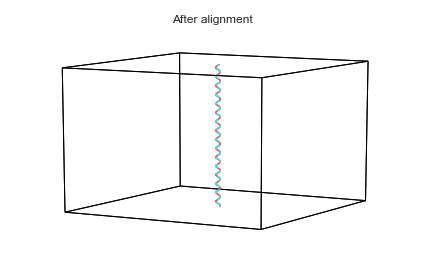

In [48]:
# load example data
data = hyp.load('spiral')
target = data.copy()

# a random rotation matrix
rot = scipy.linalg.orth(np.random.rand(3,3))

# creating new spiral with some noise
source = np.dot(target, rot)

# before hyperalignment
before = hyp.plot([target, source], ['-','--'], title='Before alignment')

# after hyperalignment
after = hyp.plot([target, source], ['-','--'], align='hyper', title='After alignment')

## Saving

To save a plot created with hypertools, simply pass the save_path argument! Let the last part of the string be the desired name of the file.

In [43]:
# geo_cluster = hyp.plot(mushrooms, '.', save_path='~/path_to_location/plot_name.pdf')